### Installations and Imports

In [1]:
#In case you don't have qiskit, install it now
%pip install qiskit --quiet
%pip install qiskit-aer --quiet
#Installing/upgrading pylatexenc seems to have fixed my mpl issue
#If you try this and it doesn't work, try also restarting the runtime/kernel
%pip install pylatexenc --quiet
%pip install numpy --quiet
%pip install matplotlib --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
#Let's go ahead and import all this stuff too
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
import numpy as np
import random
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [3]:
from qiskit.circuit.library import QFT

def built_in_qft(qc, qubits, n):

    gate=QFT(num_qubits=n, approximation_degree=0, do_swaps=False, inverse=False, insert_barriers=False, name='qft')
    qc.append(gate, qubits)

    return qc

def built_in_iqft(qc, qubits, n):

    gate=QFT(num_qubits=n, approximation_degree=0, do_swaps=False, inverse=True, insert_barriers=False, name='iqft')
    qc.append(gate, qubits)

    return qc

### Dictionaries

In [4]:
just_cards = {
    "0000": "King",
    "0001": "Ace",
    "0010": "Two",
    "0011": "Three",
    "0100": "Four",
    "0101": "Five",
    "0110": "Six",
    "0111": "Seven",
    "1000": "Eight",
    "1001": "Nine",
    "1010": "Ten",
    "1011": "Jack",
    "1100": "Queen",
}

In [5]:
binary_card_labels = {
    "0000": "King, SWAP",
    "0001": "Ace, MCX",
    "0010": "Two, H",
    "0011": "Three, SWAP",
    "0100": "Four, X",
    "0101": "Five, CX",
    "0110": "Six, MCX",
    "0111": "Seven, H",
    "1000": "Eight, SWAP",
    "1001": "Nine, X",
    "1010": "Ten, CX",
    "1011": "Jack, MCX",
    "1100": "Queen, H",
}

### Initialize the Game

In [78]:
# Create a quantum register for the dealer with 4 qubits
dealer_register = QuantumRegister(4, name='dealer')

# Create a quantum register for the player with 4 qubits
player_register = QuantumRegister(4, name='player')

aux_register = QuantumRegister(4, name='auxiliary')

dealer_classical = ClassicalRegister(4, name='dc')

player_classical = ClassicalRegister(4, name='pc')

In [79]:
reference = QuantumCircuit(dealer_register, player_register)

In [80]:
target0 = random.choice([1,2,3])
target1 = random.choice([1,2,3])
target2 = random.choice([0,2,3])
target3 = random.choice([0,2,3])

In [81]:
def create_quantum_circuit(circ, dealer_register, player_register, aux_register, dealer_classical, player_classical,
                           dealer_rotations, player_rotations, Uyou=None, Udealer=None):
    # Apply random rotations to the dealer qubits
    for i in range(4):
        for j, angle in enumerate(dealer_rotations):
            circ.rx(angle[i], dealer_register[i])
            circ.ry(angle[i], dealer_register[i])
            circ.rz(angle[i], dealer_register[i])

    # Apply random rotations to the player qubits
    for i in range(4):
        for j, angle in enumerate(player_rotations):
            circ.rx(angle[i], player_register[i])
            circ.ry(angle[i], player_register[i])
            circ.rz(angle[i], player_register[i])

    circ.barrier()
    # Incorporate Uyou and Udealer if provided
    if Uyou is not None:
        circ.compose(Uyou, inplace=True)
    if Udealer is not None:
        circ.compose(Udealer, inplace=True)

    circ.barrier()

    # These gates make it so that no 14, 15, 16 cards are dealt
    circ.mcx([dealer_register[1], dealer_register[2], dealer_register[3]], aux_register[0]) # both of these handle 1111 and 1110
    circ.mcx([player_register[1], player_register[2], player_register[3]], aux_register[2])

    circ.mcx([dealer_register[0], dealer_register[2], dealer_register[3]], aux_register[1]) # both of these handle 1101
    circ.mcx([player_register[0], player_register[2], player_register[3]], aux_register[3])

    circ.cx(aux_register[0], dealer_register[target0]) # NOTs something so they can't be an outcome
    circ.cx(aux_register[2], player_register[target1])

    circ.cx(aux_register[1], dealer_register[target2])
    circ.cx(aux_register[3], player_register[target3])

    circ.barrier()

    # Measuring
    for i in range(4):
        circ.measure(dealer_register[i], dealer_classical[i])
        circ.measure(player_register[i], player_classical[i])

    return circ

In [82]:
def measurePlot(qc):
  measure = Aer.get_backend('qasm_simulator')
  job = execute(qc, measure, shots=2048)
  result = job.result()
  counts = result.get_counts(qc)
  ###
  Keymax = max(zip(counts.values(), counts.keys()))[1]
  player_label = binary_card_labels.get(Keymax[0:4], "Label not found")
  dealer_label = binary_card_labels.get(Keymax[5:9], "Label not found")
  print(f"YOUR CARD AND GATE: {player_label}")
  print(f"DEALER'S CARD AND GATE: {dealer_label}")
  ###
  # Original dictionary
  original_dict = counts
  # Create a new dictionary with different keys but the same values
  new_dict = {}
  for old_key, value in original_dict.items():
      new_key = f'{just_cards.get(old_key[0:4])} {just_cards.get(old_key[5:9])}'  # You can customize the new key naming scheme
      new_dict[new_key] = value
  print()
  return plot_histogram(new_dict, (50, 15)), player_label, dealer_label

In [83]:
# Define the global variables
dealer_rotation_angles_x = []
dealer_rotation_angles_y = []
dealer_rotation_angles_z = []
player_rotation_angles_x = []
player_rotation_angles_y = []
player_rotation_angles_z = []

def initial_circuit_transformer(dealer_register, player_register, aux_register, dealer_classical, player_classical):
  global dealer_rotation_angles_x, dealer_rotation_angles_y, dealer_rotation_angles_z
  global player_rotation_angles_x, player_rotation_angles_y, player_rotation_angles_z
  # Generate random rotation angles for the dealer qubits
  dealer_rotation_angles_x = 2 * np.pi * np.random.rand(4)
  dealer_rotation_angles_y = 2 * np.pi * np.random.rand(4)
  dealer_rotation_angles_z = 2 * np.pi * np.random.rand(4)

  # Generate random rotation angles for the player qubits
  player_rotation_angles_x = 2 * np.pi * np.random.rand(4)
  player_rotation_angles_y = 2 * np.pi * np.random.rand(4)
  player_rotation_angles_z = 2 * np.pi * np.random.rand(4)

  # Combine dealer and player rotation angles into single variables
  dealer_rotations = [dealer_rotation_angles_x, dealer_rotation_angles_y, dealer_rotation_angles_z]
  player_rotations = [player_rotation_angles_x, player_rotation_angles_y, player_rotation_angles_z]

  # Random targets for eliminating 14, 15, and 16
  target0 = random.choice([1,2,3])
  target1 = random.choice([1,2,3])
  target2 = random.choice([0,2,3])
  target3 = random.choice([0,2,3])
  circ = QuantumCircuit(dealer_register, player_register, aux_register, dealer_classical, player_classical)
  circuit = create_quantum_circuit(circ, dealer_register, player_register, aux_register, dealer_classical, player_classical,
                                  dealer_rotations, player_rotations)
  return circuit

In [84]:
def graph_and_cards(dealer_register, player_register, aux_register, dealer_classical, player_classical):
  circuit = initial_circuit_transformer(dealer_register, player_register, aux_register, dealer_classical, player_classical)
  temp_variable = measurePlot(circuit)
  return temp_variable

In [85]:
def Uyougenerator(dealer_register, player_register, aux_register, dealer_classical, player_classical):
  # Your Turn!
  Uyou = QuantumCircuit(8)
  card_info = graph_and_cards(dealer_register, player_register, aux_register, dealer_classical, player_classical)[1]
  card_name, gate = card_info.split(", ")

  #print(f"You drew a {card_name} card.")

  if gate == "SWAP":
      control_qubit = int(input("Player: Enter the control qubit (0-7): "))
      target_qubit = int(input("Player: Enter the target qubit (0-7): "))
      Uyou.swap(control_qubit, target_qubit)
  elif gate == "MCX":
      control_qubits = list(map(int, input("Player: Enter the control qubits (comma-separated): ").split(",")))
      target_qubit = int(input("Player: Enter the target qubit (0-7): "))
      Uyou.mcx(control_qubits, target_qubit)
  elif gate == "CX":
      control_qubit = int(input("Player: Enter the control qubit (0-7): "))
      target_qubit = int(input("Player: Enter the target qubit (0-7): "))
      Uyou.cx(control_qubit, target_qubit)
  elif gate == "X":
      target_qubit = int(input("Player: Enter the target qubit (0-7): "))
      Uyou.x(target_qubit)
  elif gate == "H":
      target_qubit = int(input("Player: Enter the target qubit (0-7): "))
      Uyou.h(target_qubit)
  # Add more conditions for other gates as needed

  else:
    print("Invalid card label.")
  return Uyou

In [86]:
def Udealergenerator(dealer_register, player_register, aux_register, dealer_classical, player_classical):
  # Dealer's Turn!
  Udealer = QuantumCircuit(8)
  card_info_d = graph_and_cards(dealer_register, player_register, aux_register, dealer_classical, player_classical)[2]
  card_name_d, gate_d = card_info_d.split(", ")

  #print(f"Dealer drew a {card_name_d} card.")

  if gate_d == "SWAP":
      control_qubit_d = int(input("Dealer: Enter the control qubit (0-7): "))
      target_qubit_d = int(input("Dealer: Enter the target qubit (0-7): "))
      Udealer.swap(control_qubit_d, target_qubit_d)
  elif gate_d == "MCX":
      control_qubits_d = list(map(int, input("Dealer: Enter the control qubits (comma-separated): ").split(",")))
      target_qubit_d = int(input("Dealer: Enter the target qubit (0-7): "))
      Udealer.mcx(control_qubits_d, target_qubit_d)
  elif gate_d == "CX":
      control_qubit_d = int(input("Dealer: Enter the control qubit (0-7): "))
      target_qubit_d = int(input("Dealer: Enter the target qubit (0-7): "))
      Udealer.cx(control_qubit_d, target_qubit_d)
  elif gate_d == "X":
      target_qubit_d = int(input("Dealer: Enter the target qubit (0-7): "))
      Udealer.x(target_qubit_d)
  elif gate_d == "H":
      target_qubit_d = int(input("Dealer: Enter the target qubit (0-7): "))
      Udealer.h(target_qubit_d)
  # Add more conditions for other gates as needed

  else:
      print("Invalid card label.")
  return Udealer

In [87]:
def UCombinedGenerator(dealer_register, player_register, aux_register, dealer_classical, player_classical):
  # Your Turn!
  Uyou = QuantumCircuit(8)
  Udealer = QuantumCircuit(8)
  Ugraph, card_info, card_info_d = graph_and_cards(dealer_register, player_register, aux_register, dealer_classical, player_classical)
  print("hi")
  display(Ugraph)
  print("bye")

  Ugraph.show()

  time.sleep(2)

  plt.close(Ugraph)
  print("GATE TIME!")
  #print(f"help {card_info}")
  card_name, gate = card_info.split(", ")
  ##
  #print(f"You drew a {card_name} card.")

  if gate == "SWAP":
      control_qubit = int(input("Player: Enter the control qubit (0-7): "))
      target_qubit = int(input("Player: Enter the target qubit (0-7): "))
      Uyou.swap(control_qubit, target_qubit)
  elif gate == "MCX":
      control_qubits = list(map(int, input("Player: Enter the control qubits (comma-separated): ").split(",")))
      target_qubit = int(input("Player: Enter the target qubit (0-7): "))
      Uyou.mcx(control_qubits, target_qubit)
  elif gate == "CX":
      control_qubit = int(input("Player: Enter the control qubit (0-7): "))
      target_qubit = int(input("Player: Enter the target qubit (0-7): "))
      Uyou.cx(control_qubit, target_qubit)
  elif gate == "X":
      target_qubit = int(input("Player: Enter the target qubit (0-7): "))
      Uyou.x(target_qubit)
  elif gate == "H":
      target_qubit = int(input("Player: Enter the target qubit (0-7): "))
      Uyou.h(target_qubit)
  # Add more conditions for other gates as needed

  else:
    print("Invalid card label.")
  #############
  card_name_d, gate_d = card_info_d.split(", ")

  print("")
  print("")
  #print(f"Dealer drew a {card_name_d} card.")
  #print(gate_d)
  if gate_d == "SWAP":
      control_qubit_d = int(input("Dealer: Enter the control qubit (0-7): "))
      target_qubit_d = int(input("Dealer: Enter the target qubit (0-7): "))
      Udealer.swap(control_qubit_d, target_qubit_d)
  elif gate_d == "MCX":
      control_qubits_d = list(map(int, input("Dealer: Enter the control qubits (comma-separated): ").split(",")))
      target_qubit_d = int(input("Dealer: Enter the target qubit (0-7): "))
      Udealer.mcx(control_qubits_d, target_qubit_d)
  elif gate_d == "CX":
      control_qubit_d = int(input("Dealer: Enter the control qubit (0-7): "))
      target_qubit_d = int(input("Dealer: Enter the target qubit (0-7): "))
      Udealer.cx(control_qubit_d, target_qubit_d)
  elif gate_d == "X":
      target_qubit_d = int(input("Dealer: Enter the target qubit (0-7): "))
      Udealer.x(target_qubit_d)
  elif gate_d == "H":
      target_qubit_d = int(input("Dealer: Enter the target qubit (0-7): "))
      Udealer.h(target_qubit_d)
  # Add more conditions for other gates as needed

  else:
      print("Invalid card label.")
  return Uyou, Udealer, Ugraph

In [88]:
def Usupergen(dealer_register, player_register, aux_register, dealer_classical, player_classical):
  Uyou, Udealer, Ugraph = UCombinedGenerator(dealer_register, player_register, aux_register, dealer_classical, player_classical)
  print("ugraph from supergen")
  display(Ugraph)
  return Ugraph, Uyou, Udealer

### User Friendliness

In [20]:
# Combine dealer and player rotation angles into single variables
dealer_rotations = [dealer_rotation_angles_x, dealer_rotation_angles_y, dealer_rotation_angles_z]
player_rotations = [player_rotation_angles_x, player_rotation_angles_y, player_rotation_angles_z]

In [71]:
def circ2gen(dealer_register, player_register, aux_register, dealer_classical, player_classical, dealer_rotations, player_rotations):
  usupervar, uyousuper, udealersuper = Usupergen(dealer_register, player_register, aux_register, dealer_classical, player_classical)

  circ2 = QuantumCircuit(dealer_register, player_register, aux_register, dealer_classical, player_classical)
  circuit2 = create_quantum_circuit(circ2, dealer_register, player_register, aux_register, dealer_classical, player_classical,
                                  dealer_rotations, player_rotations, uyousuper, udealersuper)


  display(circuit2.draw('mpl'))
  print("measure circuit 2")
  display(measurePlot(circuit2)[0])
  return measurePlot(circuit2)[1:]

In [22]:
def blackjack_card_values(dealer_register, player_register, aux_register, dealer_classical, player_classical, dealer_rotations, player_rotations):
    # Define a dictionary to map card names to their corresponding values in blackjack
    card1, card2 = circ2gen(dealer_register, player_register, aux_register, dealer_classical, player_classical, dealer_rotations, player_rotations)
    card_values = {
        'Two': 2, 'Three': 3, 'Four': 4, 'Five': 5, 'Six': 6, 'Seven': 7, 'Eight': 8, 'Nine': 9,
        'Ten': 10, 'Jack': 10, 'Queen': 10, 'King': 10, 'Ace': 1
    }

    # Split the input strings into individual card names
    card1_name = card1.split(',')[0].strip()
    card2_name = card2.split(',')[0].strip()

    # Look up the values for the cards and return them as a tuple
    return (card_values.get(card1_name, 0), card_values.get(card2_name, 0))

In [23]:
def card_counter_reseter(dealer_register, player_register, aux_register, dealer_classical, player_classical, dealer_rotations, player_rotations, playercont, dealercont):
    # Check if the player's count is 21 or over
    print("Current Score")
    print(f"Player: {playercont}")
    print(f"Dealer: {dealercont}")
    if playercont >= 21:
        if playercont == 21:
            print("Player wins with a count of 21!")
            return "Player Win"
        else:
            print("Dealer wins because the player went over 21.")
            return "Dealer Win"

    # Check if the dealer's count is 21 or over
    if dealercont >= 21:
        if dealercont == 21:
            print("Dealer wins with a count of 21!")
            return "Dealer Win"
        else:
            print("Player wins because the dealer went over 21.")
            return "Player Win"

    playercontplus, dealercontplus = blackjack_card_values(dealer_register, player_register, aux_register, dealer_classical, player_classical, dealer_rotations, player_rotations)
    playercont += playercontplus
    dealercont += dealercontplus


    # Create a quantum register for the dealer with 4 qubits
    dealer_register = QuantumRegister(4, name='dealer')

    # Create a quantum register for the player with 4 qubits
    player_register = QuantumRegister(4, name='player')

    aux_register = QuantumRegister(4, name='auxiliary')

    dealer_classical = ClassicalRegister(4, name='dc')

    player_classical = ClassicalRegister(4, name='pc')

    card_counter_reseter(dealer_register, player_register, aux_register, dealer_classical, player_classical, dealer_rotations, player_rotations, playercont, dealercont)


### Rules

<font color=pink> Try and get to 21! All card numbers are represented in binary, but remember that the King is 0000. </font>

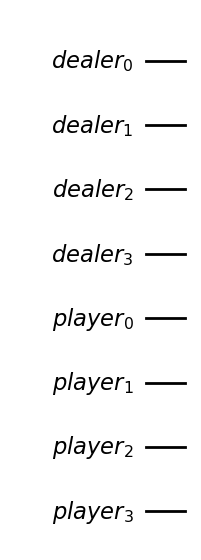

In [19]:
reference.draw('mpl')

### Start!

Current Score
Player: 0
Dealer: 0
YOUR CARD AND GATE: Queen, H
DEALER'S CARD AND GATE: Seven, H

hi


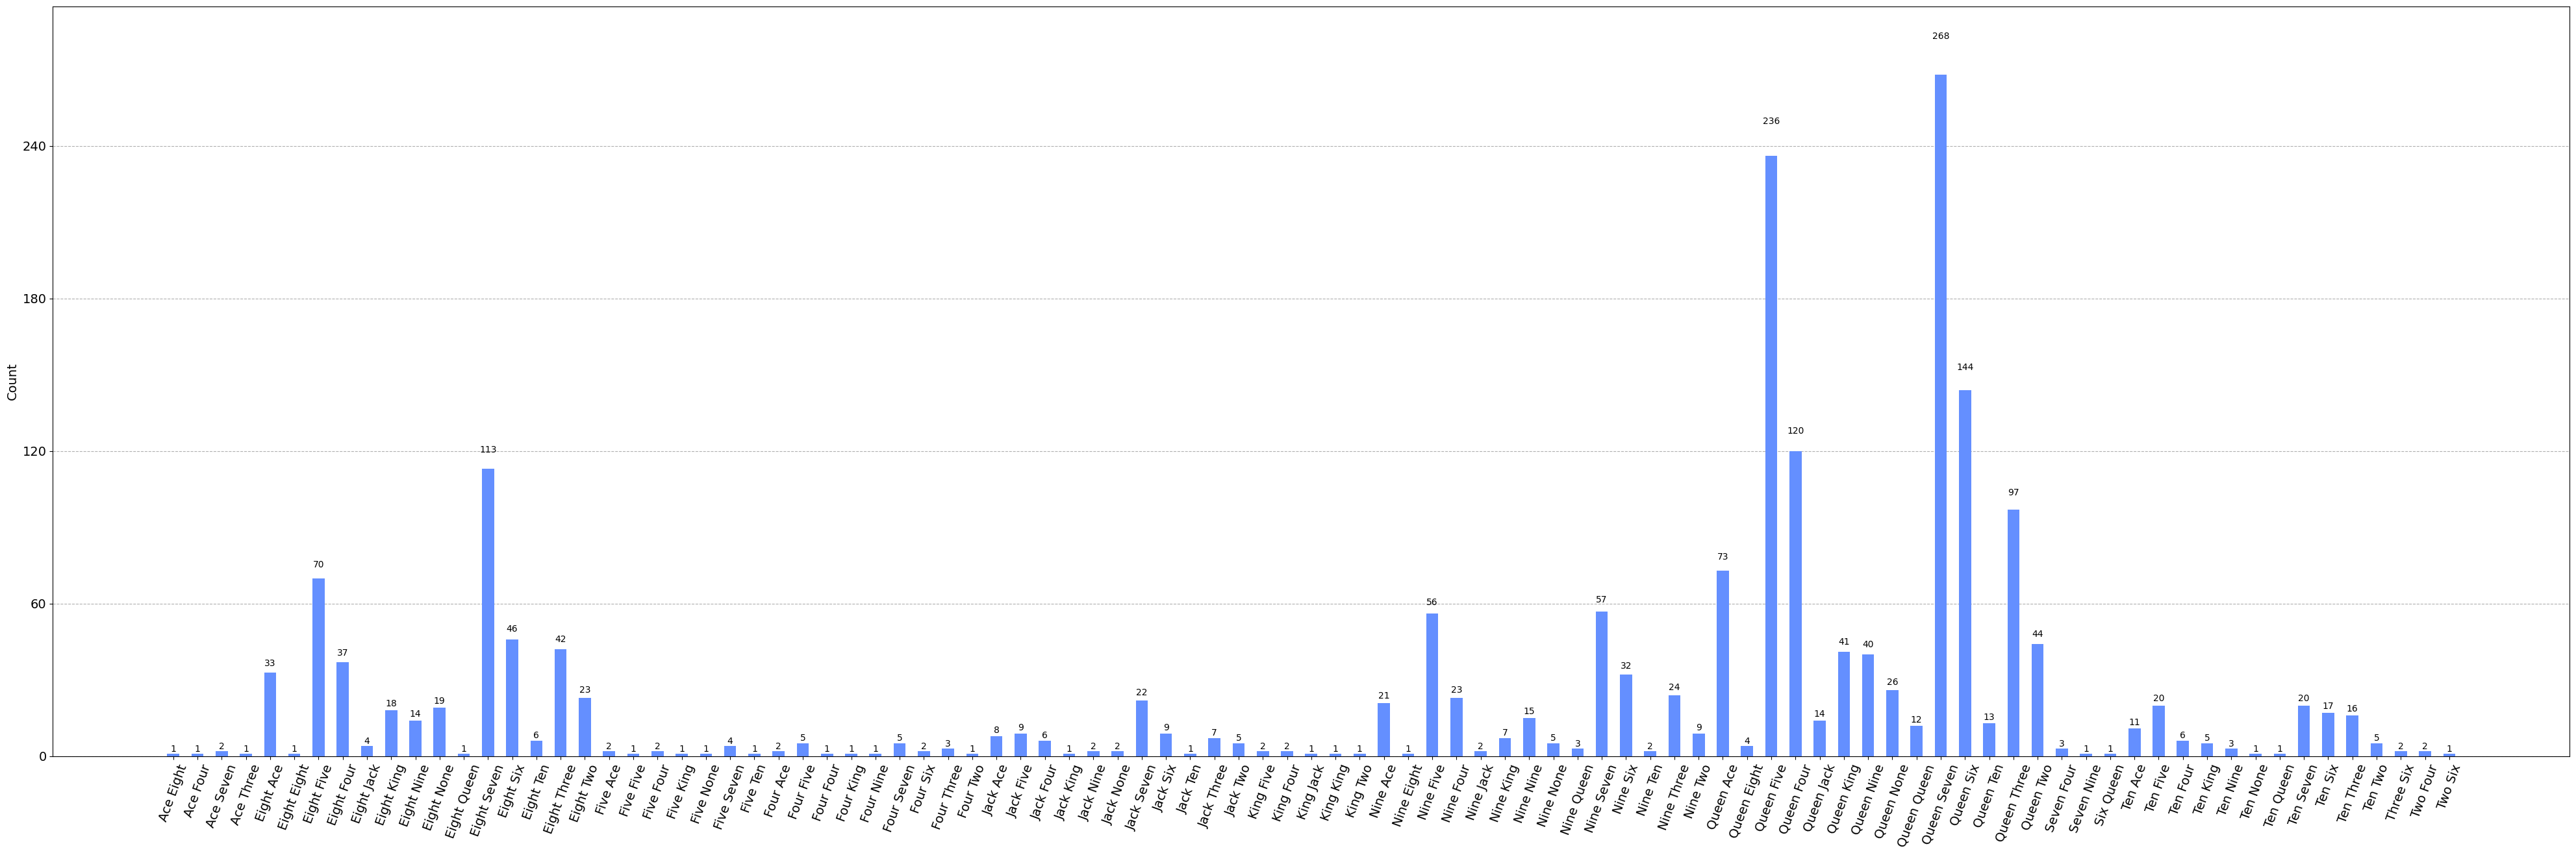

bye
GATE TIME!
Player: Enter the target qubit (0-7): 1


Dealer: Enter the target qubit (0-7): 1
ugraph from supergen


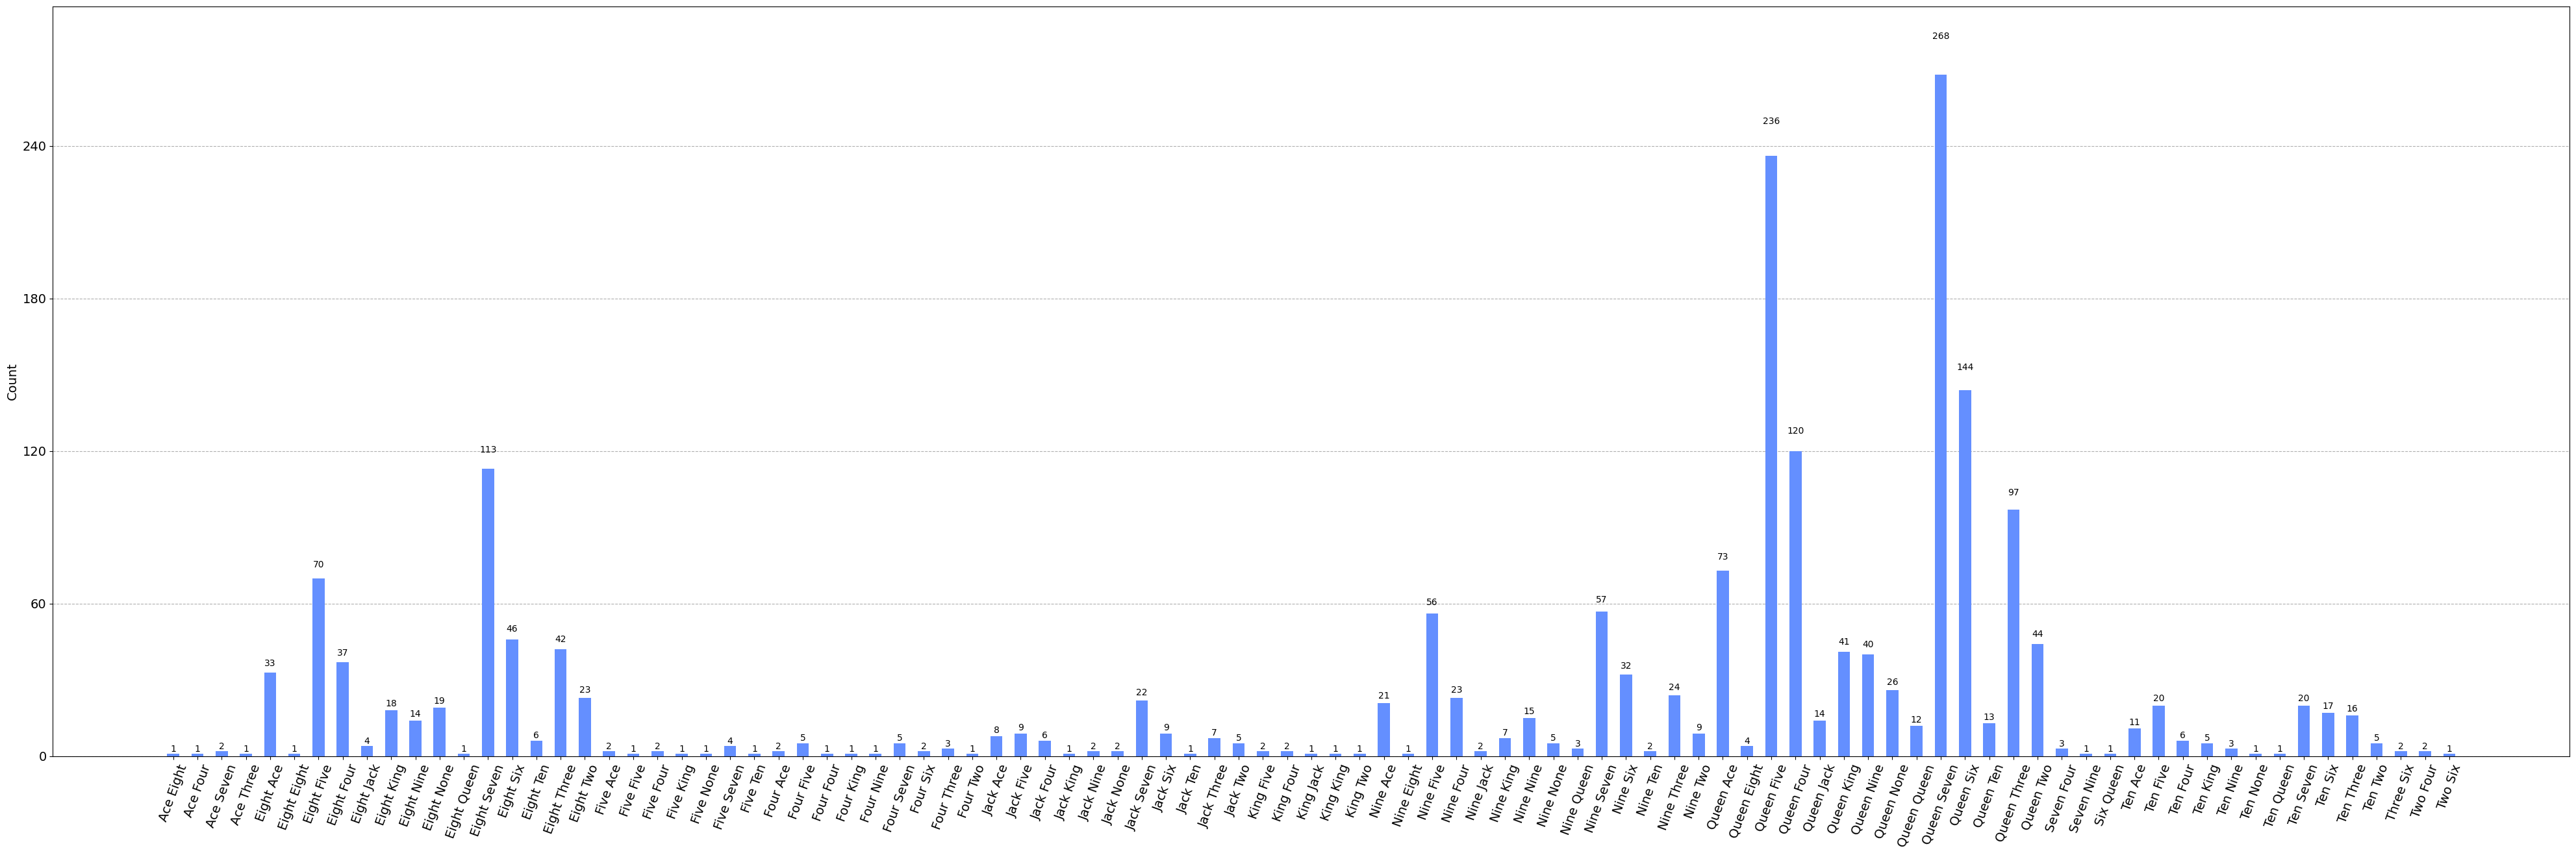

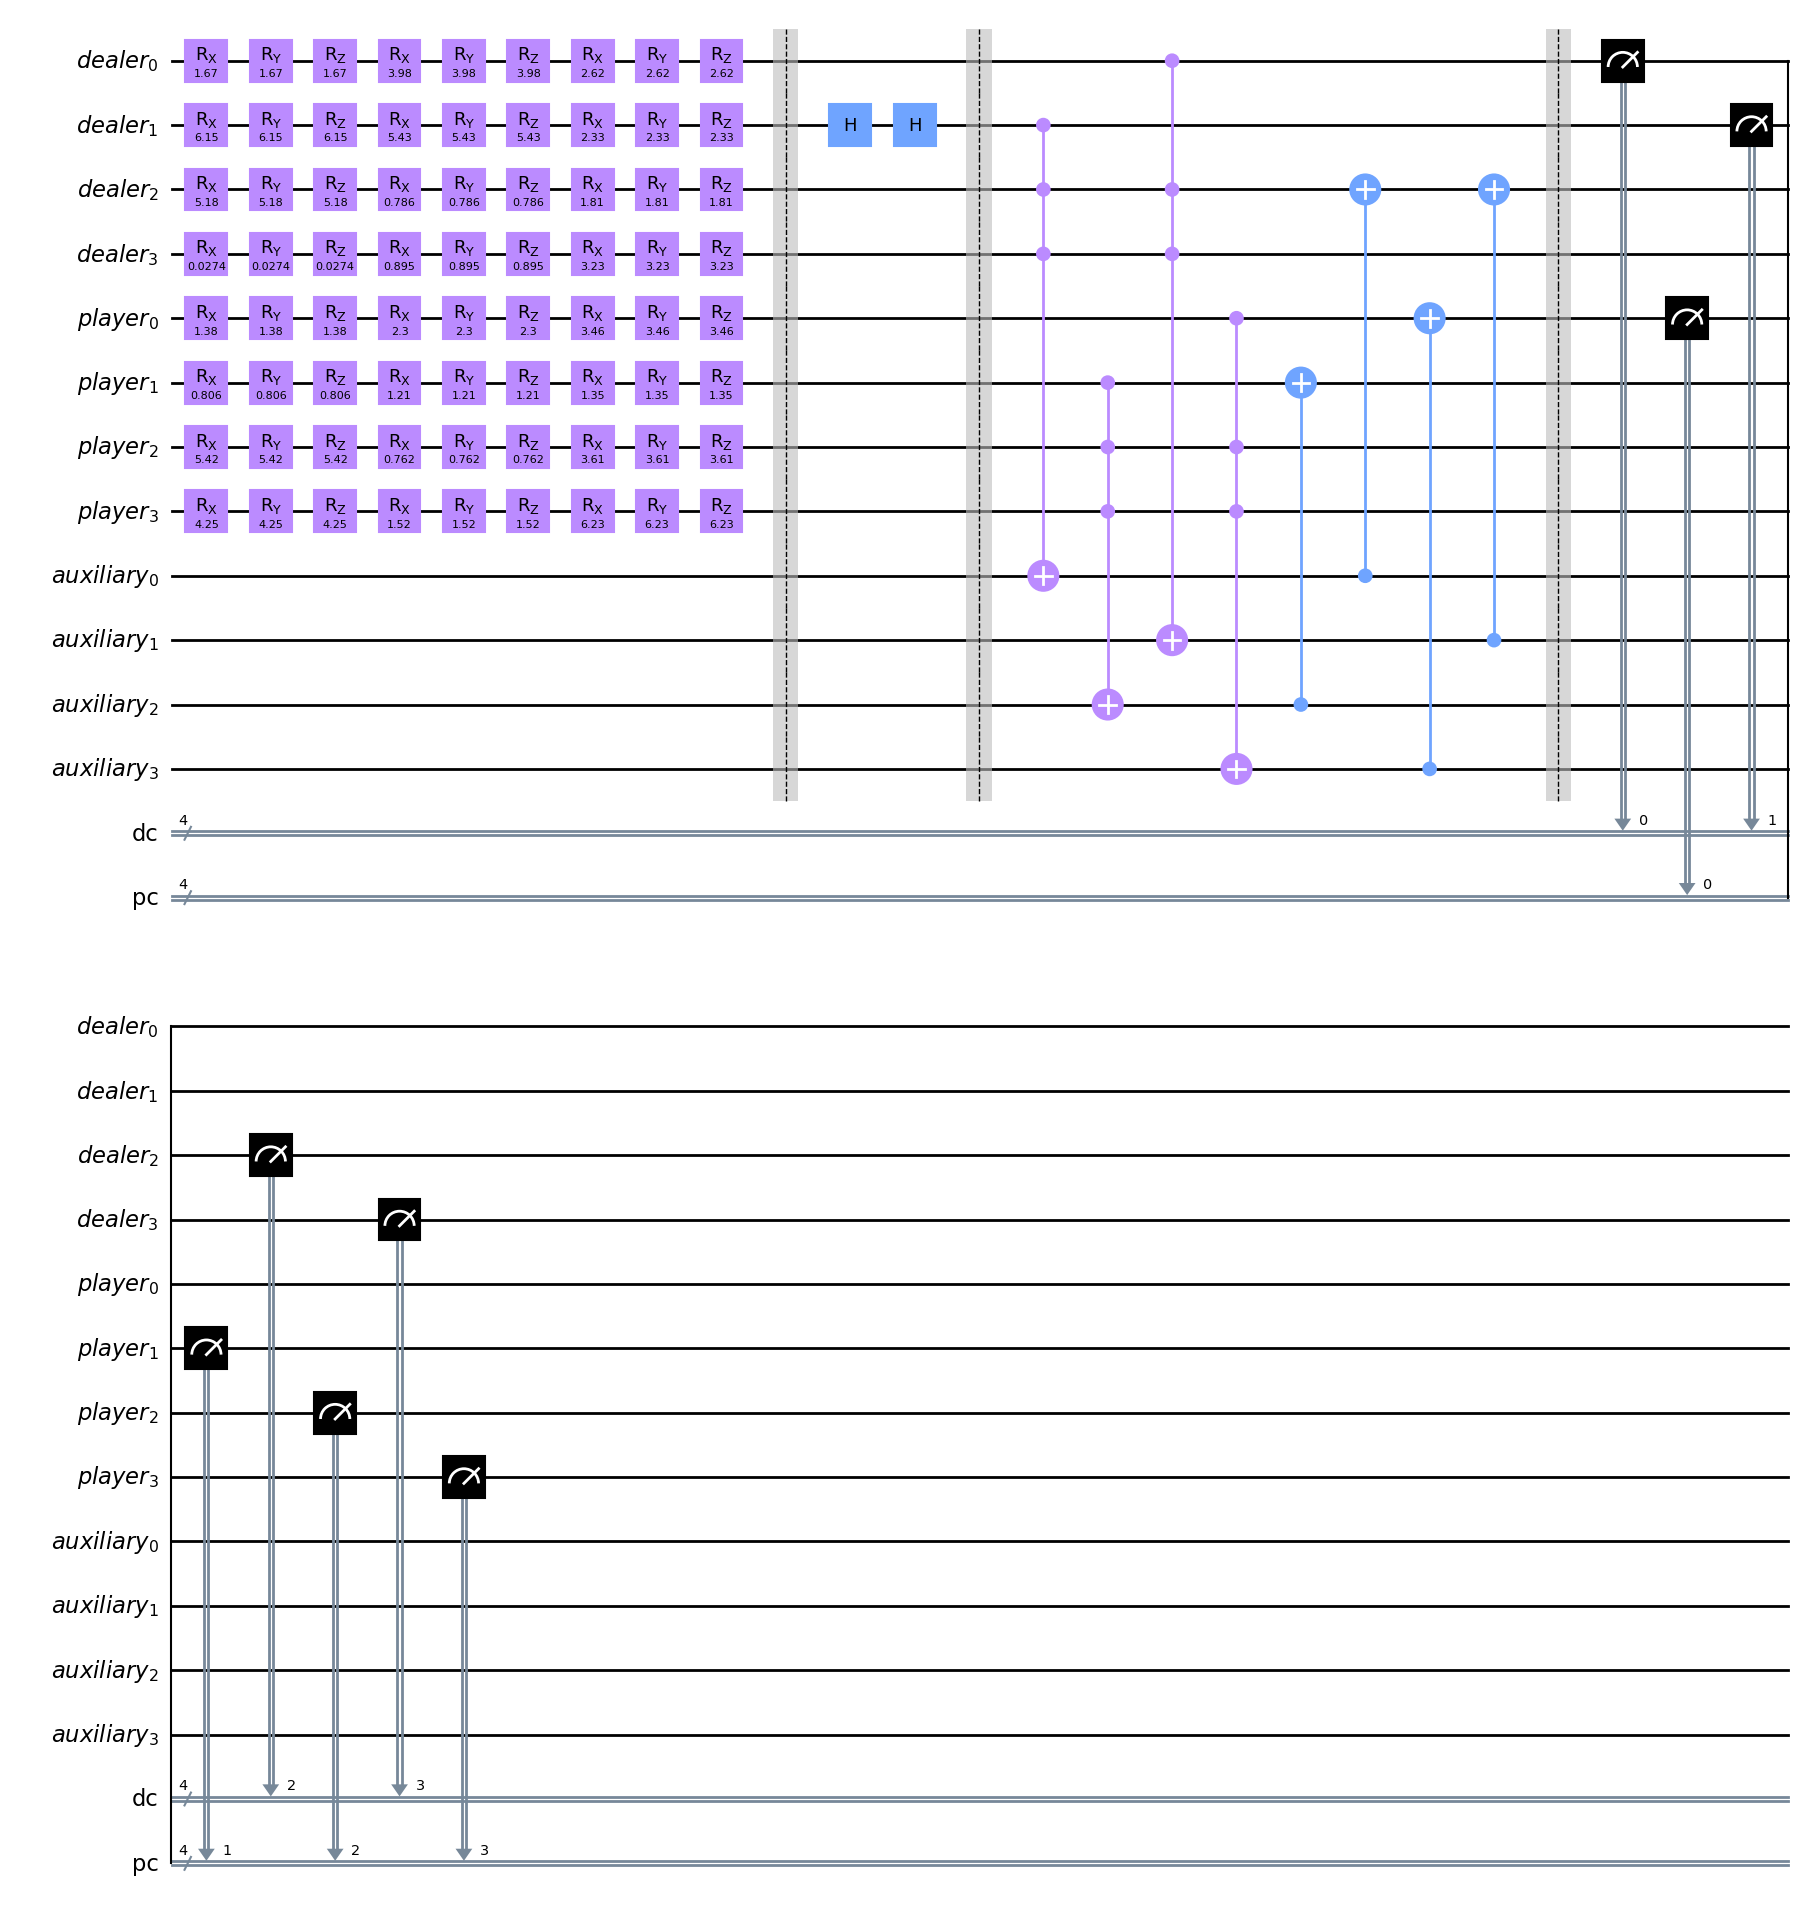

measure circuit 2
YOUR CARD AND GATE: Jack, MCX
DEALER'S CARD AND GATE: Six, MCX



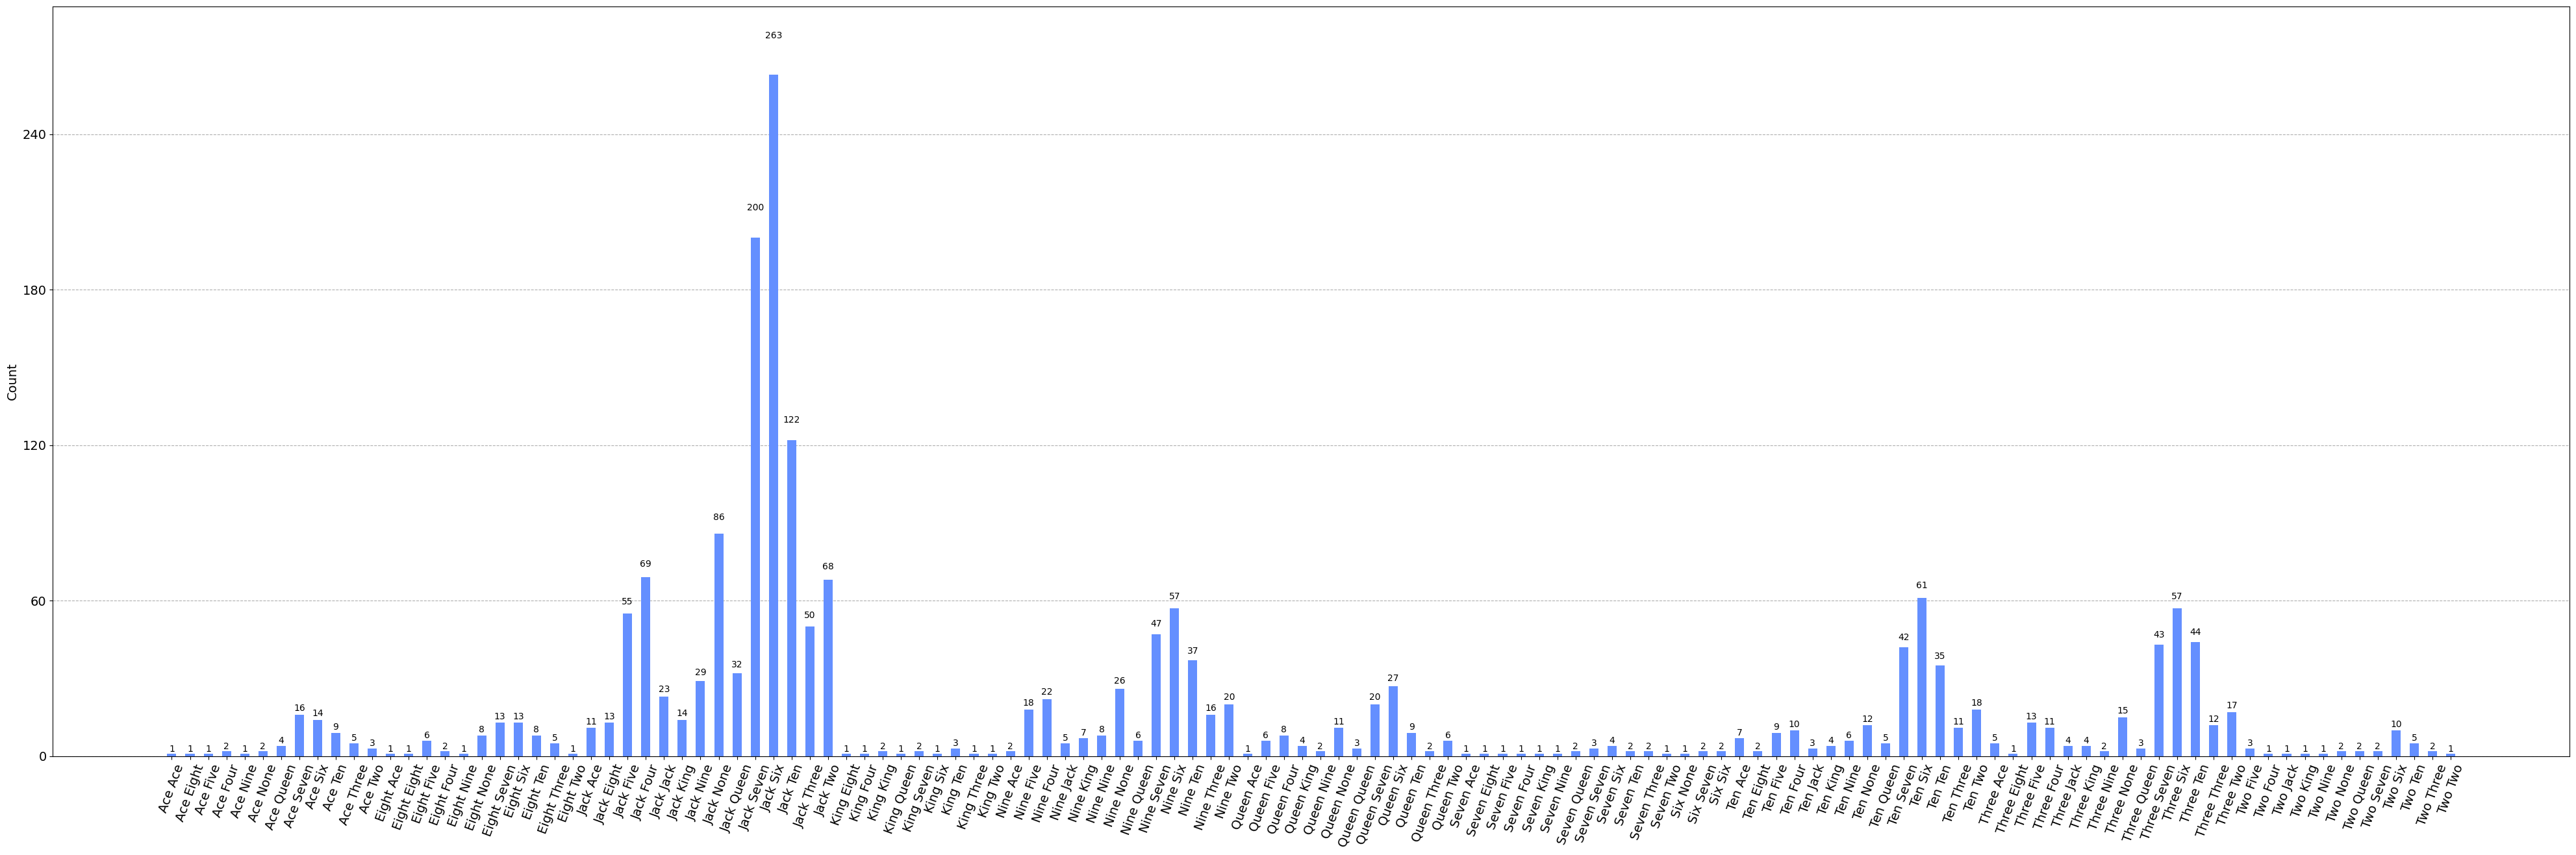

YOUR CARD AND GATE: Jack, MCX
DEALER'S CARD AND GATE: Six, MCX

Current Score
Player: 10
Dealer: 6
YOUR CARD AND GATE: Six, MCX
DEALER'S CARD AND GATE: Ace, MCX

hi


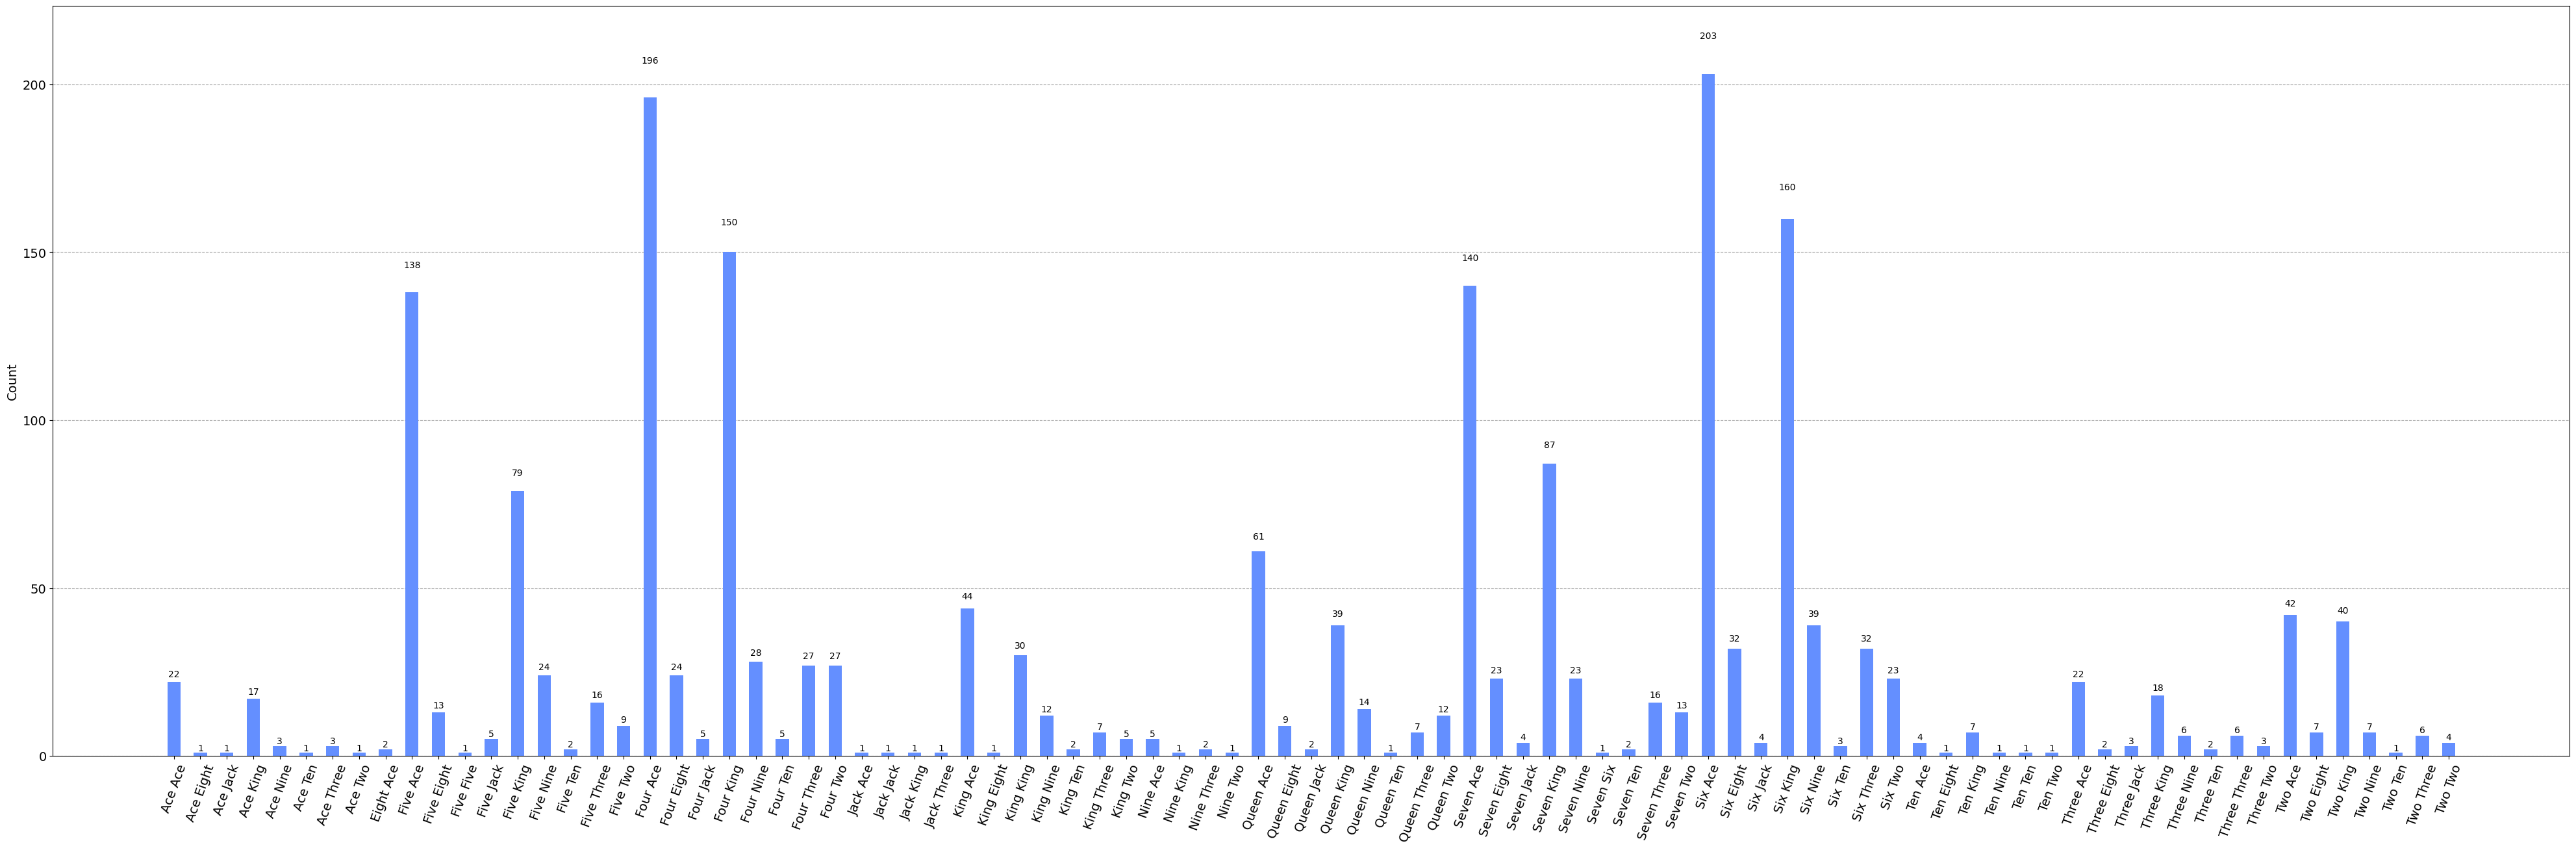

bye
GATE TIME!


KeyboardInterrupt: ignored

In [91]:
card_counter_reseter(dealer_register, player_register, aux_register, dealer_classical, player_classical, dealer_rotations, player_rotations, 0, 0)